In [1]:
import torch
from torch import nn
from torch import optim
from torch.distributions import MultivariateNormal

import matplotlib.pyplot as plt

In [18]:
class GaussianParticle(nn.Module):    
    def __init__(self, dim=2, mean=0, var=1):
        super().__init__()
        self.dim = dim
        self.loc = nn.parameter.Parameter(mean*torch.ones(self.dim), requires_grad=True)
        self.cov = nn.parameter.Parameter(var*torch.eye(self.dim), requires_grad=True)
        self._lmbda = nn.parameter.Parameter(torch.tensor(0.5), requires_grad=True)
        
        self.mvn = MultivariateNormal(
            loc=self.loc.view(1, self.dim),
            scale_tril=self.cov.view(1, self.dim, self.dim)
        )
    def lmbda(self):
        # Trick to implement the constraint on lambda:
        return torch.sigmoid(self._lmbda)

    def log_prob(self, X):
        return self.mvn.log_prob(X)

    def sample(self, nsamples=100):
        return self.mvn.sample([nsamples])

In [19]:
def FKLLoss(samples, p, q, f):
    ps = p.log_prob(samples)
    qs = q.log_prob(samples)
    fs = f.log_prob(samples)
    l = f.lmbda()

    r = torch.exp(ps-qs)
    w = r / r.sum()

    return torch.matmul(torch.transpose(w, 0, 1), ps - torch.log(l*torch.exp(fs) + (1-l)*torch.exp(qs))).squeeze()

In [35]:
model = GaussianParticle(dim=2)

q = MultivariateNormal(loc=torch.zeros(2), covariance_matrix=torch.diag(5*torch.ones(2)))

p = MultivariateNormal(loc=torch.ones(2), covariance_matrix=torch.diag(0.3*torch.ones(2)))

opt = optim.SGD(model.parameters(), lr=0.001)

losses = []
for step in range(2000):

    samples = model.sample(nsamples=200)
    loss = FKLLoss(samples, p, q, model)

    if step%200==0:
        print(f'step:{step}, loss:{loss.detach().numpy()}')

    losses.append(loss.detach().numpy())

    opt.zero_grad()
    loss.backward()
    opt.step()

step:0, loss:1.3163156509399414
step:200, loss:1.03444504737854
step:400, loss:1.2060304880142212
step:600, loss:0.9336186051368713
step:800, loss:0.7914047241210938
step:1000, loss:0.49071022868156433
step:1200, loss:0.2732080817222595
step:1400, loss:-0.1673460751771927
step:1600, loss:-0.7986576557159424
step:1800, loss:-1.92043936252594


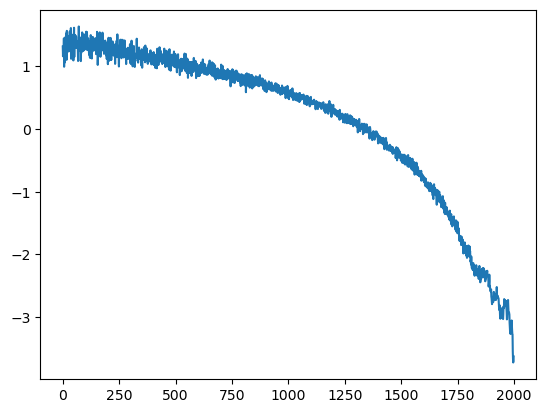

In [36]:
plt.plot(losses)
plt.show()